# 00 — Exploratory Data Analysis (EDA)

Exploratory Data Analysis is the first and fundamental step of this project. In this phase, our goal is to become familiar with the dataset and develop an initial understanding of its structure, content, and underlying patterns. We carefully explore the data by examining its dimensions, inspecting image labels, and analyzing the distribution of the features available to us.

Through visualization and descriptive analysis, we aim to identify relevant characteristics of the data, detect potential irregularities, and gain intuition about how the images are represented in the feature space. This exploratory process is essential, as it allows us to make informed decisions before applying more advanced techniques.

Overall, this notebook lays the groundwork for the subsequent stages of the project, providing the necessary context and intuition for feature extraction and clustering methods that will be introduced later.

## 1. Imports

In this section, we import all the Python libraries required for the Exploratory Data Analysis (EDA).

These libraries allow us to handle files and directories, process and manipulate data, visualize images and distributions, and track progress during data loading and preprocessing. Together, they provide the basic tools needed to explore and understand the dataset.

In [6]:
import os
import glob

from PIL import Image
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from google.colab import drive
from collections import Counter

## 2. Mounting drive and locating dataset

This step sets up access to the dataset and defines a consistent directory structure that will be used throughout the project.

We begin by mounting Google Drive in the Colab environment to enable access to the ZIP file containing the PatternMind dataset. Working directly from Drive ensures reproducibility and avoids repeated uploads across sessions.

Next, we define the key paths required for dataset management:

- `ZIP_PATH`: absolute path to the dataset ZIP file stored in Google Drive  
- `UNZIP_DIR`: destination directory where the ZIP file will be extracted  
- `DATASET_DIR_NAME`: name of the dataset folder inside the ZIP archive  
- `DATA_ROOT`: full path to the extracted dataset directory  

Once the extraction is completed, we verify that `DATA_ROOT` exists and list its contents. This validation step ensures that the dataset has been correctly unzipped, that the expected directory structure is present, and that the data is ready to be used in subsequent preprocessing and analysis stages.

In [7]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
ZIP_PATH = "/content/drive/MyDrive/patternmind_dataset.zip"
UNZIP_DIR = "/content/patternmind_unzipped"
DATASET_DIR_NAME = "patternmind_dataset"

DATA_ROOT = os.path.join(UNZIP_DIR, DATASET_DIR_NAME)
print("Will use DATA_ROOT:", DATA_ROOT)

Will use DATA_ROOT: /content/patternmind_unzipped/patternmind_dataset


In [9]:
if not os.path.isdir(DATA_ROOT):
    os.makedirs(UNZIP_DIR, exist_ok=True)
    !unzip -q "{ZIP_PATH}" -d "{UNZIP_DIR}"
    print("Unzipped dataset.")
else:
    print("Dataset already unzipped.")

Dataset already unzipped.


We list the contents of the extracted directory to verify that the dataset has been correctly unzipped.

The output confirms that `DATA_ROOT` exists and that the extraction was successful. In addition to the dataset folder, a system directory named `__MACOSX` is present. This folder is automatically created when ZIP archives are generated on macOS and does not contain any relevant data for the project. It can safely be ignored in the following steps.

In [10]:
print("DATA_ROOT exists:", os.path.isdir(DATA_ROOT))
print("Contents of UNZIP_DIR:", os.listdir(UNZIP_DIR))

DATA_ROOT exists: True
Contents of UNZIP_DIR: ['patternmind_dataset', '__MACOSX']


## 3. Load Dataset and Basic Information

In this step, we load the dataset from the extracted directory and inspect its basic structure to gain an initial understanding of its organization.

Specifically, we examine:
- the total number of images
- the folder-based image structure
- any available labels (if present)
- the overall dataset organization

The dataset is organized into subdirectories, each corresponding to a distinct class. By listing these folders, we can verify how many classes are available and inspect a sample of class names. This information is useful for understanding the scale of the dataset and for guiding subsequent preprocessing and analysis steps.


In [11]:
root = DATA_ROOT

folders = [d for d in os.listdir(root)
                 if os.path.isdir(os.path.join(root, d))]

print("Number of class folders:", len(folders))
print("First 20 class folders:", folders[:20])

Number of class folders: 233
First 20 class folders: ['microscope', 'mattress', 'giraffe', 'laptop', 'microwave', 'killer-whale', 'yo-yo', 'soda-can', 'top-hat', 'watch', 'hibiscus', 'hot-air-balloon', 'knife', 'tower-pisa', 'umbrella', 'lightbulb', 'radio-telescope', 'computer-keyboard', 'raccoon', 'eyeglasses']


## 4. Collect All Image Paths

In this step, we recursively scan the dataset directory to collect the file paths of all images contained in the dataset.

We restrict the search to common image formats to ensure consistency across the project. The supported file extensions are:
- `.jpg`
- `.jpeg`
- `.png`

By traversing the directory structure and aggregating all matching file paths, we obtain the complete list of images that will be used throughout the project. This list serves as a central reference for subsequent processing steps such as visualization, feature extraction, and clustering.


In [12]:
DATA_DIR = UNZIP_DIR
extensions = ['*.jpg', '*.jpeg', '*.png']
image_paths = []

for ext in extensions:
    image_paths.extend(glob.glob(os.path.join(DATA_DIR, '**', ext), recursive=True))

print("Total images found:", len(image_paths))
image_paths[:5]

Total images found: 25557


['/content/patternmind_unzipped/patternmind_dataset/microscope/microscope_16.jpg',
 '/content/patternmind_unzipped/patternmind_dataset/microscope/microscope_78.jpg',
 '/content/patternmind_unzipped/patternmind_dataset/microscope/microscope_18.jpg',
 '/content/patternmind_unzipped/patternmind_dataset/microscope/microscope_24.jpg',
 '/content/patternmind_unzipped/patternmind_dataset/microscope/microscope_50.jpg']

## 5. Extract Class Labels from Folder Structure

Each image in the dataset is stored inside a directory corresponding to its class label. We leverage this folder-based organization to automatically extract class labels from the file paths.

For each image path, the label is obtained from the name of its parent directory. This approach allows us to infer labels without relying on an external annotation file.

Using this information, we construct a structured DataFrame containing:
- `path`: the full file path of each image  
- `label`: the class label derived from the folder name  

This representation enables us to verify the dataset organization and compute useful statistics such as:
- class distribution  
- total number of images per class  
- detection of empty or missing class folders  

These checks provide an important sanity check before proceeding with further analysis and feature extraction.


In [13]:
# folder name = class label
def get_class_from_path(path):
    return os.path.basename(os.path.dirname(path))

labels = [get_class_from_path(p) for p in image_paths]

df = pd.DataFrame({
    "path": image_paths,
    "label": labels
})

df.head()

,path,label
0,/content/patternmind_unzipped/patternmind_data...,microscope
1,/content/patternmind_unzipped/patternmind_data...,microscope
2,/content/patternmind_unzipped/patternmind_data...,microscope
3,/content/patternmind_unzipped/patternmind_data...,microscope
4,/content/patternmind_unzipped/patternmind_data...,microscope


## 6. Class Distribution

In this step, we analyze how images are distributed across the different classes in the dataset by counting how many images appear in each class folder.

This analysis helps identify potential issues such as:
- class imbalance, where some classes contain significantly more images than others  
- empty class folders with no associated images  
- incorrectly named or unexpected folders  

By computing and inspecting the class distribution, we gain a clearer understanding of the dataset composition. This information is particularly important for guiding downstream tasks, such as sampling strategies, feature extraction, and the interpretation of clustering results.


In [14]:
class_counts = df["label"].value_counts().sort_values(ascending=False)

print("Number of classes:", len(class_counts))
class_counts.head(10)


Number of classes: 233


,count
label,
clutter,761
airplanes,720
motorbikes,719
faces-easy,396
t-shirt,330
hammock,257
billiards,251
horse,246
ladder,223


The histogram below shows the distribution of the number of images per class in the dataset.

Most classes contain a relatively small number of images, while a few classes have significantly more samples. This indicates a noticeable class imbalance, which is common in large-scale, real-world image datasets.

Understanding this distribution is important, as class imbalance can influence downstream tasks such as clustering quality and the interpretation of learned feature representations. In later stages, this insight can guide decisions related to sampling strategies or evaluation of results.

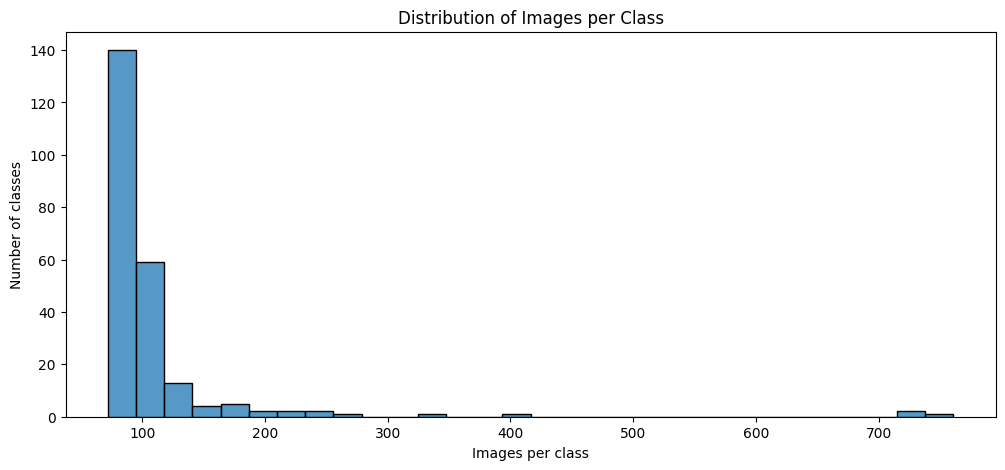

In [15]:
plt.figure(figsize=(12, 5))
sns.histplot(class_counts, bins=30)
plt.title("Distribution of Images per Class")
plt.xlabel("Images per class")
plt.ylabel("Number of classes")
plt.show()

## 7. Checking for Empty Folders, Duplicates, and Corrupted Images

In this step, we perform a series of data quality checks to ensure that the dataset is clean and consistent before proceeding further.

Specifically, we check for:
- **Empty folders**: class directories that contain zero images  
- **Duplicate filenames**: cases where the same filename appears in multiple class folders, which may indicate duplicated or mislabeled images  
- **Corrupted images**: files that cannot be opened correctly using the PIL library  

These checks help validate the integrity of the dataset and confirm that the folder structure is coherent and complete. Ensuring data quality at this stage reduces the risk of errors and unexpected behavior in downstream processing steps such as feature extraction and clustering.


In [16]:
folder_counts = {}

for cls in folders:
    cls_path = os.path.join(root, cls)
    images = [f for f in os.listdir(cls_path)
              if os.path.isfile(os.path.join(cls_path, f))]
    folder_counts[cls] = len(images)

print("Total folders:", len(folder_counts))
print("Total images:", sum(folder_counts.values()))

Total folders: 233
Total images: 25558


In [17]:
empty_folders = [cls for cls, count in folder_counts.items() if count == 0]
print("Empty folders:", empty_folders if empty_folders else "None")

Empty folders: None


In [18]:
all_files = []

for cls in folders:
    for file in os.listdir(os.path.join(root, cls)):
        if os.path.isfile(os.path.join(root, cls, file)):
            all_files.append(file)

name_counts = Counter(all_files)
duplicates = [name for name, cnt in name_counts.items() if cnt > 1]

print("Duplicate filenames:", len(duplicates))
print("Examples:", duplicates[:234])

Duplicate filenames: 0
Examples: []


In [19]:
bad_files = []

for path in tqdm(image_paths, desc="Checking corrupted images"):
    try:
        img = Image.open(path)
        img.verify()   # verify file integrity
    except Exception:
        bad_files.append(path)

print("Corrupted files found:", len(bad_files))

Checking corrupted images: 100%|██████████| 25557/25557 [00:15<00:00, 1610.67it/s]

Corrupted files found: 0


## 8. File Extensions

In this step, we analyze the distribution of file extensions across the dataset to verify format consistency and detect any unexpected image types.

By computing the frequency of each file extension (e.g., `.jpg`, `.jpeg`, `.png`), we confirm that all images follow a uniform format. This check helps prevent compatibility issues in later stages of the project, such as image loading, preprocessing, and feature extraction.

This analysis also confirms the assumptions made earlier when collecting image paths, validating that the dataset contains only the expected image formats.


In [20]:
exts = df["path"].apply(lambda x: os.path.splitext(x)[1].lower()).value_counts()
exts

,count
path,
.jpg,25557


## 9. Basic Dimension Statistics (Sample of 200 Images)

To understand the variability in image resolutions across the dataset, we randomly select a sample of 200 images and measure their width and height.

For this subset, we compute basic summary statistics such as the mean, median, minimum, and maximum dimensions. Sampling allows us to efficiently estimate resolution characteristics without processing the entire dataset.

This analysis helps verify:
- whether image sizes are relatively consistent across classes  
- whether extreme resolution outliers are present  
- how much resizing or normalization will be required during preprocessing  

Understanding image dimension variability is important for designing downstream processing steps, particularly feature extraction pipelines that require fixed input sizes.


In [21]:
sample_paths = np.random.choice(image_paths, size=200, replace=False)

widths, heights = [], []

for p in sample_paths:
    try:
        img = Image.open(p)
        w, h = img.size
        widths.append(w)
        heights.append(h)
    except:
        pass

print("Avg width:", np.mean(widths))
print("Avg height:", np.mean(heights))

Avg width: 363.965
Avg height: 321.745


## 10. Building a DataFrame for EDA

In this step, we construct a pandas DataFrame that aggregates relevant metadata for each image in the dataset. Centralizing this information in a tabular format simplifies further exploratory analysis and enables efficient computation of summary statistics.

For each image, we store the following attributes:
- `filepath`: full path to the image file  
- `class` (or `label`): class name derived from the parent folder  
- `filename`: basename of the image file  
- `width`, `height`: image dimensions in pixels, read using PIL  
- `extension`: file extension (e.g., `.jpg`, `.png`)  

This DataFrame provides a structured representation of the dataset and allows us to:
- inspect basic statistics across images and classes  
- detect unusual or inconsistent image dimensions  
- verify file format consistency  
- compute class distributions and other aggregate measures  

Having this unified DataFrame is particularly useful for downstream exploratory analysis, visualization, and as a foundation for feature extraction and modeling steps.


In [22]:
data = {
    "filepath": [],
    "class": [],
    "filename": [],
    "width": [],
    "height": [],
    "extension": []
}

for cls in folders:
    cls_path = os.path.join(root, cls)

    for file in os.listdir(cls_path):
        file_path = os.path.join(cls_path, file)
        if not os.path.isfile(file_path):
            continue

        ext = file.split(".")[-1].lower()

        try:
            img = Image.open(file_path)
            width, height = img.size
        except:
            width, height = None, None

        data["filepath"].append(file_path)
        data["class"].append(cls)
        data["filename"].append(file)
        data["width"].append(width)
        data["height"].append(height)
        data["extension"].append(ext)

df = pd.DataFrame(data)
df.head()

,filepath,class,filename,width,height,extension
0,/content/patternmind_unzipped/patternmind_data...,microscope,microscope_16.jpg,200.0,360.0,jpg
1,/content/patternmind_unzipped/patternmind_data...,microscope,microscope_78.jpg,384.0,288.0,jpg
2,/content/patternmind_unzipped/patternmind_data...,microscope,microscope_18.jpg,1200.0,1639.0,jpg
3,/content/patternmind_unzipped/patternmind_data...,microscope,microscope_24.jpg,250.0,178.0,jpg
4,/content/patternmind_unzipped/patternmind_data...,microscope,microscope_50.jpg,375.0,500.0,jpg


## 11. EDA Summary Plots

In this step, we create simple visual summaries to consolidate insights gathered during the exploratory data analysis phase.

First, we visualize the number of images per class using a bar plot. This representation provides a clear overview of class balance and highlights the presence of class imbalance across the dataset.

In addition, we inspect summary statistics derived from the metadata DataFrame, such as image width and height distributions. These visual and numerical summaries help identify potential anomalies, including extremely small or unusually large images.

Overall, these plots provide a compact visual overview of the dataset and support informed decisions for subsequent preprocessing, feature extraction, and modeling steps.


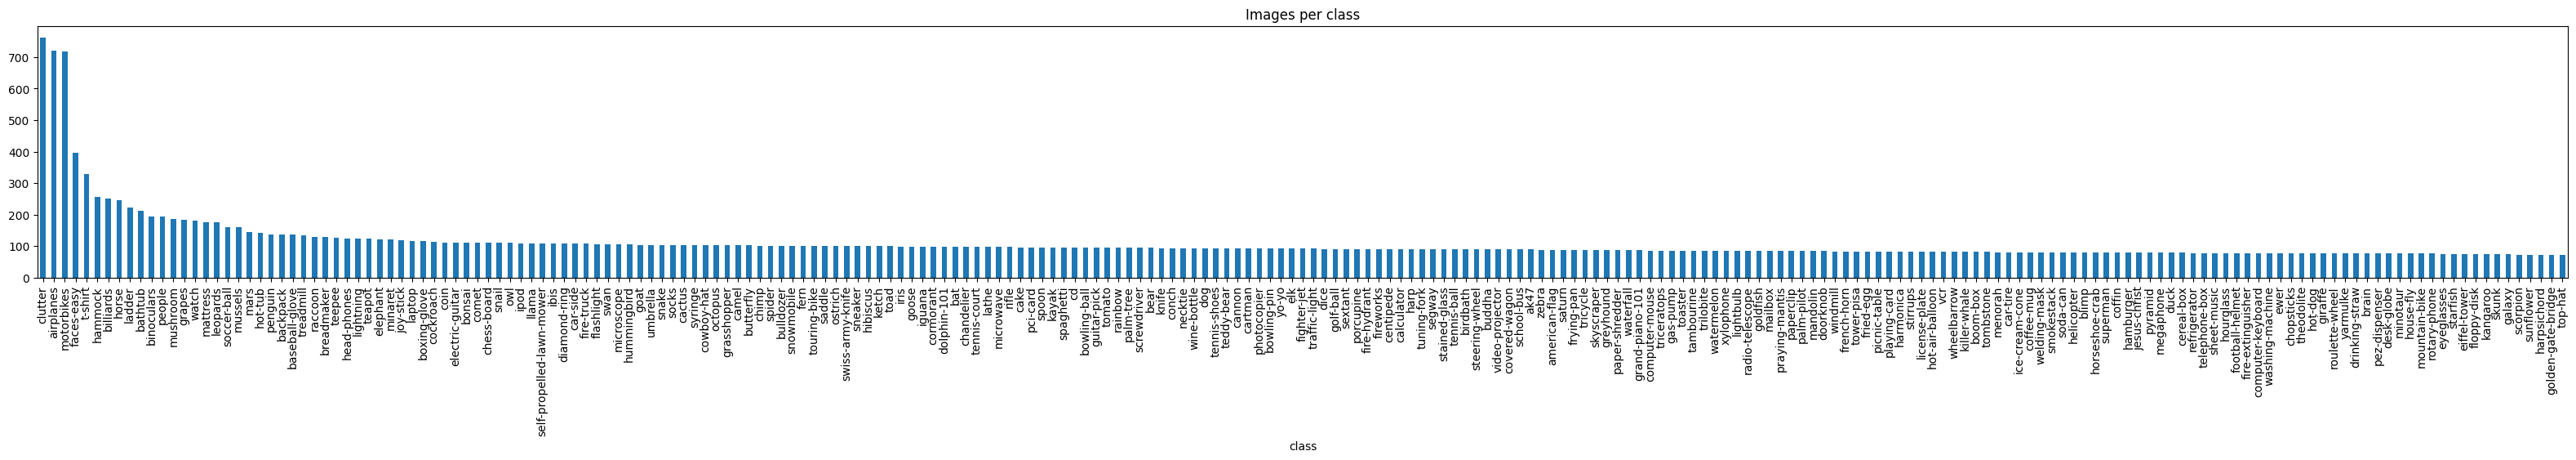

In [23]:
df['class'].value_counts().plot(kind='bar', figsize=(40,4))
plt.title("Images per class")
plt.show()

In [24]:
df[['width','height']].describe()

,width,height
count,25557.000000,25557.000000
mean,371.891810,326.044137
std,229.095197,206.907445
min,100.000000,97.000000
25%,238.000000,200.000000
50%,300.000000,280.000000
75%,442.000000,397.000000
max,7913.000000,7913.000000


## 12. Final Summary

At the end of the exploratory data analysis, we provide a compact textual summary that consolidates the key characteristics of the dataset.

Specifically, we report:
- the total number of categories (classes)  
- the total number of images  
- the presence or absence of empty class folders  
- the number of corrupted images detected  
- the set of file extensions found in the dataset  

This summary serves as a final validation step, confirming that the dataset is complete, consistent, and free of major quality issues. It also provides a clear reference point before moving on to feature extraction and clustering in the next phase of the project.


In [25]:
print("Data set summary:")
print("Total categories:", len(folders))
print("Total images:", sum(folder_counts.values()))
print("Empty folders:", empty_folders if empty_folders else "None")
print("Corrupted images:", len(bad_files))
print("File extensions:", extensions)

Data set summary:
Total categories: 233
Total images: 25558
Empty folders: None
Corrupted images: 0
File extensions: ['*.jpg', '*.jpeg', '*.png']
